# Analysis of the Titanic

In this first section we are going to conduct an an exploratory data analysis of the titanic dataset. 

The goal is to understand the data and identify patterns and insights that can be used to answer questions about the passengers on board of the titanic.

## Importing Required Libraries

In [1]:
import warnings
from typing import Dict, List, Union

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

warnings.filterwarnings('ignore')

## Data Cleaning

### First Visual Inspection

In [2]:
# Read data
df = pd.read_csv("data/Titanic-Dataset.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


According to [Thomas E. Cason](https://campus.lakeforest.edu/frank/FILES/MLFfiles/Bio150/Titanic/TitanicMETA.pdf) we have the following variable descriptions:

 - `Survived` => Survival (0 = No; 1 = Yes)
 - `Pclass` => Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
 - `Name` => Passenger Full Name
 - `Sex` => Male or Female ('male' and 'female')
 - `Age` => Age in years of the passenger
 - `SibSp` => Number of Siblings/Spouses Aboard
 - `Parch` => Number of Parents/Children Aboard
 - `Ticket` => Ticket Number
 - `Fare` => Passenger Fare (British pound)
 - `Cabin` => Cabin Number
 - `Embarked` => Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

In [3]:
df.shape

(891, 12)

There seem to be a total of `891` passengers listed in this dataset set.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Based on this new information we should probably transform the data to make it more understandable.

- `PassengerId` is a unique identifier for each passenger and does not provide any useful information for our analysis. We can drop this column.
- `Name` can be dropped as well as it does not provide any useful information for our analysis.
- `Ticket` can be dropped as well as it does not provide any useful information for our analysis.
- `Sex` can be transformed into either 0 or 1 for male and female respectively.
- `Sex` and `Embarked` can be transformed into categories

In [5]:
df.drop(columns=['PassengerId', 'Name', 'Ticket'], inplace=True)
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

for col in ['Sex','Embarked']:
    df[col] = df[col].astype('category')

Moreover, the above reveals that a there are missing values in the `Age`, `Cabin` and `Embarked` columns.

In order to have a better visual understanding lets plot a heatmap to see the missing values.

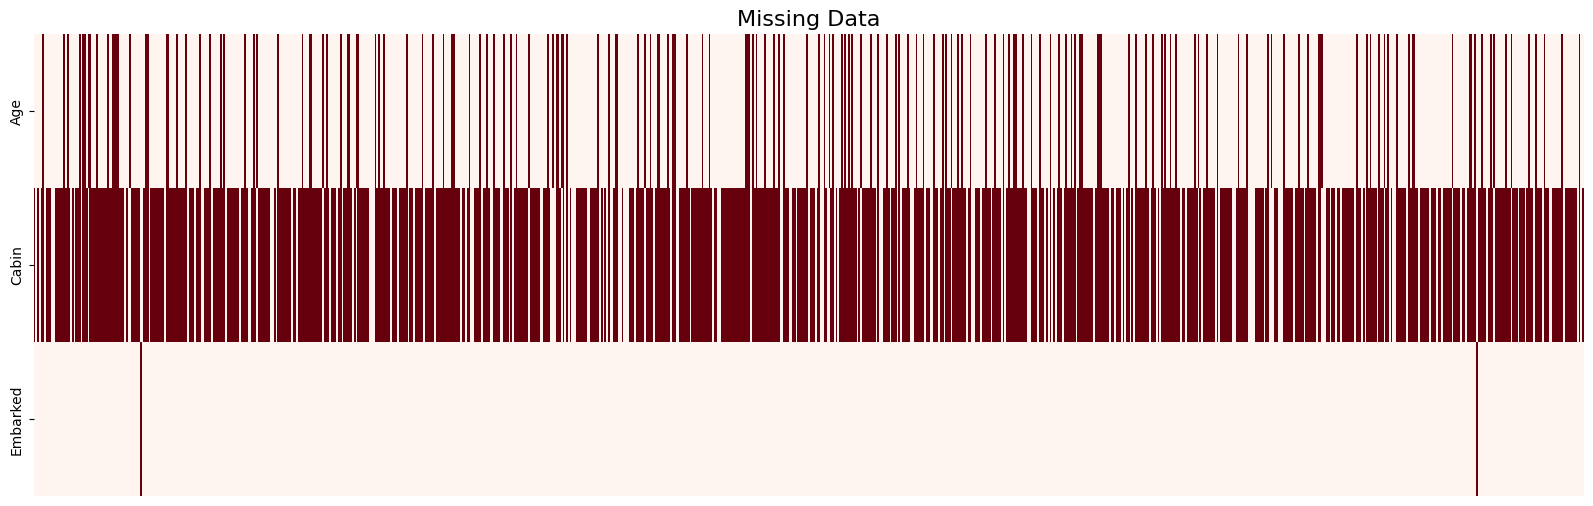

In [6]:
plt.figure(figsize=(20, 6))
sns.heatmap(df[['Age', 'Cabin', 'Embarked']].isnull().T, cbar=False, cmap='Reds', xticklabels=False)
plt.title('Missing Data', fontsize=16)
plt.show()

In [7]:
def print_missing_values_percentage(df: pd.DataFrame, columns: List[str]) -> None:
    """
    Prints the percentage of missing values for specified columns in a DataFrame.

    :param df: The pandas DataFrame to analyze.
    :param columns: A list of column names to check for missing values.
    """
    for column in columns:
        if column in df.columns:
            missing_percentage = df[column].isna().sum() / df[column].shape[0]
            print(f"Percentage of missing values in '{column}' column: {missing_percentage:.2%}")
        else:
            print(f"Column '{column}' does not exist in the DataFrame.")

print_missing_values_percentage(df, ['Age', 'Cabin', 'Embarked'])

Percentage of missing values in 'Age' column: 19.87%
Percentage of missing values in 'Cabin' column: 77.10%
Percentage of missing values in 'Embarked' column: 0.22%


The `Age` variable has approximately 19.87% missing values, which is a manageable proportion for "data imputation" using values derived from other columns.\
The `Embarked` variable has only 0.22% missing values (two data points), which is negligible and can be safely dropped without significantly impacting the analysis.

In contrast, the `Cabin` column has too much missing data to be effectively used in its current form, hence it will be dropped.

In [8]:
df.drop(columns=['Cabin'], inplace=True)
df.dropna(subset=['Embarked'], inplace=True)
print(f"Now we 'only' have {df.shape[0]} data points left.")

Now we 'only' have 889 data points left.


### Data Imputation

I want to investigate a better approach for filling the missing values in the `Age` variable, rather than simply using the overall average (global mean).

My hypothesis is that `Age` is strongly influenced by Passenger Class `Pclass` and `Sex`.\
The reasoning behind this is that 1st class passengers, being generally wealthier during that time, were likely older compared to those in 3rd class.\
Additionally, women might have tended to be younger than their male counterparts.

To validate this assumption, I'll analyze the data and see if it holds true.

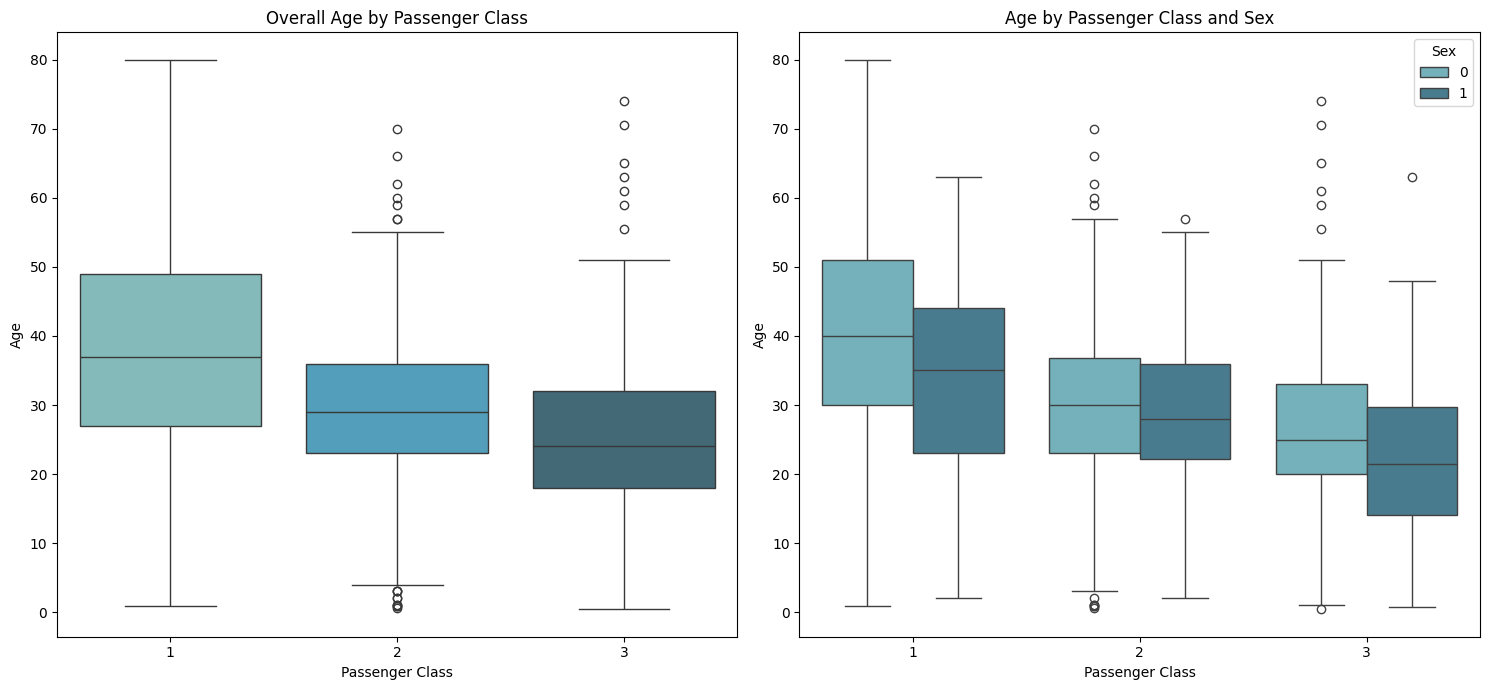

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

sns.boxplot(x='Pclass', y='Age', data=df, palette='GnBu_d', ax=axes[0])
axes[0].set_title('Overall Age by Passenger Class')
axes[0].set_xlabel('Passenger Class')

sns.boxplot(x='Pclass', y='Age', hue='Sex', data=df, palette='GnBu_d', ax=axes[1])
axes[1].set_title('Age by Passenger Class and Sex')
axes[1].set_xlabel('Passenger Class')
axes[1].legend(title='Sex')

plt.tight_layout()
plt.show()

The left plot shows the **overall age distribution** among the passenger classes.\
The box plot reveals a larger interquartile range (IQR) suggesting that 1st class passengers had a broader spread of older ages.\
Most first class passengers where between 27 and 49 years old, while second and third class passengers were younger.\
However, we have more outliers indicated by the box plots for the second a third class passengers.

The right plot shows the **age distribution** among the passenger classes **separated by sex**.
The box plot reveals that **women were indeed younger than men** across all passenger classes.

The data and visualizations strongly support the hypothesis, hence let's build an imputation method that takes this into account.

In [10]:
# Pre-computed dictionary containing mean ages rounded by Sex and Pclass
MEAN_AGE_BY_PCLASS_AND_SEX_ROUNDED: Dict[str, Dict[int, float]] = (
    df.groupby(['Sex', 'Pclass'])['Age']
    .mean()
    .round()
    .unstack()
    .to_dict()
) # type: ignore
MEAN_AGE_BY_PCLASS_AND_SEX_ROUNDED

{1: {0: 41.0, 1: 34.0}, 2: {0: 31.0, 1: 29.0}, 3: {0: 27.0, 1: 22.0}}

Let's impute the `Age` by the above values for 1-3 class passengers by sex (0 or 1).

In [11]:
def impute_age(row: pd.Series) -> Union[float, None]:
    """
    Impute missing age based on the mean age for the corresponding Sex and Passenger Class (Pclass).

    Parameters:
        row (pd.Series): A row of the DataFrame containing 'Age', 'Pclass', and 'Sex'.

    Returns:
        float: The imputed age if missing.
        None: Returns None if 'Sex' or 'Pclass' is invalid or not in the precomputed dictionary.
    """
    age = row['Age']
    sex = row['Sex']
    pclass = row['Pclass']
    
    if pd.notnull(age):
        return age

    # Validate input before attempting to retrieve mean age
    if pclass not in MEAN_AGE_BY_PCLASS_AND_SEX_ROUNDED:
        raise ValueError(
            f"Invalid Pclass value '{pclass}'. Allowed values: {list(MEAN_AGE_BY_PCLASS_AND_SEX_ROUNDED.keys())}"
        )
    
    if sex not in MEAN_AGE_BY_PCLASS_AND_SEX_ROUNDED[pclass]:
        raise ValueError(
            f"Invalid Sex value '{sex}' for Pclass '{pclass}'. Allowed values: {list(MEAN_AGE_BY_PCLASS_AND_SEX_ROUNDED[pclass].keys())}"
        )
    
    return MEAN_AGE_BY_PCLASS_AND_SEX_ROUNDED[pclass][sex]

df['Age'] = df.apply(impute_age, axis=1)

In [12]:
df.isna().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

We have successfully imputed all missing values now.

## Exploratory Data Analysis